In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
import matplotlib.ticker as plticker

from data_collection.analysis.utils import get_tweets_from_json_file, is_covid_related_tweet, get_tweet_words
from data_collection.analysis import visualizations as vz

In [3]:
tweets = get_tweets_from_json_file("ug_tweets")

In [4]:
print(len(tweets))

20000


In [108]:
def process_tweet(tweet: dict) -> dict:
    """Process tweets from raw files"""
    user_id = tweet['author_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
    is_covid = is_covid_related_tweet(words)
    source = tweet['source']

    return {
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement,
        'is_covid': is_covid,
        'source': source
    }


def create_pd_from_tweets(tweets) -> pd.DataFrame:
    df = pd.DataFrame([process_tweet(tweet) for tweet in tweets])
#     df.set_index('created_time', inplace=True)
    return df

In [109]:
df = create_pd_from_tweets(tweets)
df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce').dt.date

In [110]:
df.head()

,user_id,tweet_id,created_time,text,words,retweet_count,reply_count,quote_count,like_count,engagement,is_covid,source
0,628614226,1366176238373634048,2021-02-28,Happy New month https://t.co/4QRUVHFiw2,"[happy, month]",2,7,0,183,192,False,Twitter for Android
1,1169513881489858561,1366176080260976647,2021-02-28,RT @macyjemi: Anyone awake 🧐??\n I want us to ...,"[anyone, awake, want, talk, something, urgent]",3,0,0,0,3,False,Twitter for Android
2,894261468,1366175958970093568,2021-02-28,RT @ssenfukamalik: Members of Majlis Khuddamul...,"[members, majlis, khuddamul, ahmadiyya, uganda...",13,0,0,0,13,False,Twitter for iPhone
3,1284584639420600320,1366175795035729920,2021-02-28,Anyone awake 🧐??\n I want us to talk something...,"[anyone, awake, want, talk, something, urgent]",3,10,0,43,56,False,Twitter for Android
4,1284584639420600320,1366175439178366976,2021-02-28,@123rayrunner Naye gwe twakola loss 😂😂😂🤣🤣,"[naye, twakola, loss, 😂😂😂🤣🤣]",0,1,0,2,3,False,Twitter for Android


In [89]:
vz.summary(df)

Number of tweets: 20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        20000 non-null  object
 1   tweet_id       20000 non-null  object
 2   created_time   20000 non-null  object
 3   text           20000 non-null  object
 4   words          20000 non-null  object
 5   retweet_count  20000 non-null  int64 
 6   reply_count    20000 non-null  int64 
 7   quote_count    20000 non-null  int64 
 8   like_count     20000 non-null  int64 
 9   engagement     20000 non-null  int64 
 10  is_covid       20000 non-null  bool  
 11  source         20000 non-null  object
dtypes: bool(1), int64(5), object(6)
memory usage: 1.7+ MB
Columns:
None


In [111]:
covid_df = df[df['is_covid'] == True]

In [112]:
covid_df.head()

,user_id,tweet_id,created_time,text,words,retweet_count,reply_count,quote_count,like_count,engagement,is_covid,source
14,912204877757059072,1366170863561760768,2021-02-28,"@ntvuganda Sheikh Muzata was killed, I'd doesn...","[sheikh, muzata, killed, need, bishop, archbis...",0,0,0,0,0,True,Twitter for Android
492,1346361755593814017,1366126207612448772,2021-02-28,@Rociwells2021 @karmajusticiera @PODEMOS @nach...,"[llevas, toda, razón, pero, necesitas, twitter...",0,0,0,0,0,True,Twitter for Android
1507,1246539661306138630,1366093048489336833,2021-02-28,RT @douglasrasbash: @TheRealRuncey @SkyNews Tr...,"[true, covid, graves, prepared, outside, paulo]",1,0,0,0,1,True,Twitter for iPhone
1764,2184672177,1366084886696783872,2021-02-28,RT @douglasrasbash: @Elliemaexx__ @SkyNews Abo...,"[virus, mutations, recorded, whether, fear, co...",1,0,0,0,1,True,Twitter for iPhone
1778,1013221658,1366084217445249024,2021-02-28,@Elliemaexx__ @SkyNews About 40 virus mutation...,"[virus, mutations, recorded, whether, fear, co...",1,0,0,3,4,True,Twitter for iPhone


Number of COVID tweets: 38


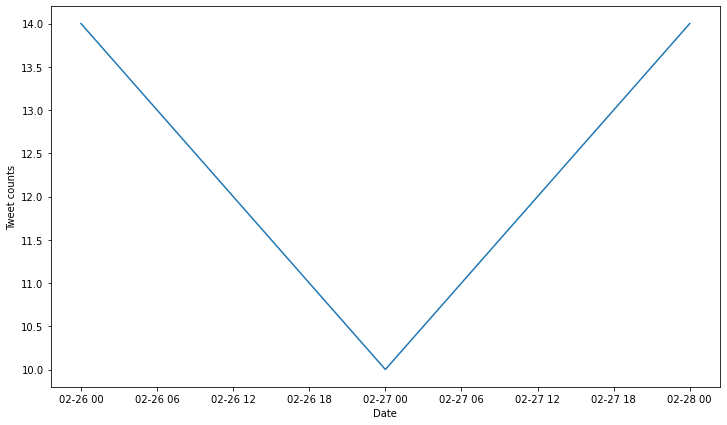

In [116]:
def summarise_covid_tweets(covid_df: pd.DataFrame, mode="moh"):
    print(f"Number of COVID tweets: {covid_df.shape[0]}")

    daily_covid = covid_df['tweet_id'].groupby([covid_df['created_time']]).count()
    ax = daily_covid.plot(figsize=(12, 7))
    ax.set(ylabel="Tweet counts")
    ax.set(xlabel="Date")

    plt.show()

summarise_covid_tweets(covid_df)

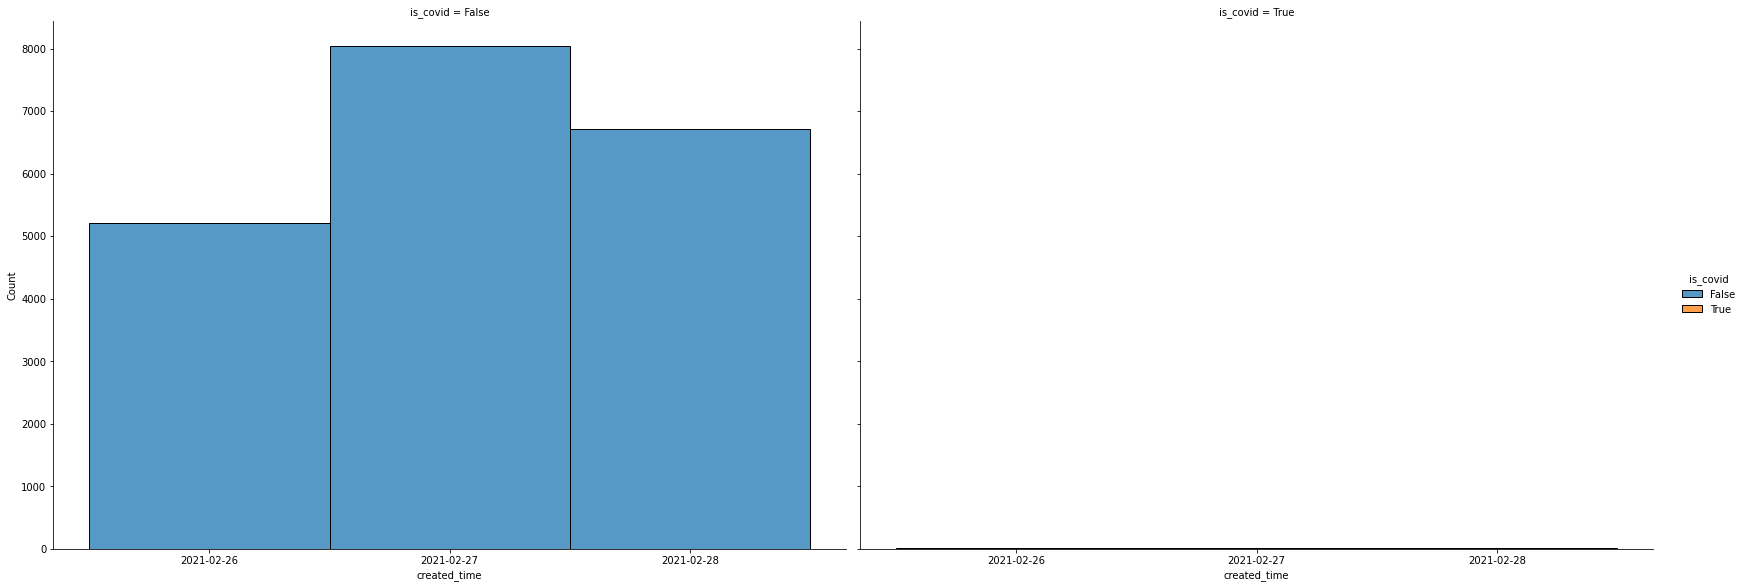

In [125]:
# _, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8)
g = sns.displot(df, x="created_time", hue="is_covid", col='is_covid', height=8.27, aspect=11.7/8.27)
x_dates = df['created_time'].sort_values().unique()
# g.set_xticklabels(labels=x_dates, rotation=45, horizontalalignment='right')
g.set(xticks=x_dates)
# g.fig.autofmt_xdate()